# Model Training with Synthetic Data - Analysis

In [2]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import seaborn as sns

In [3]:
# define helper functions

def return_results(predictions_csv, classes, confusion=True):
    ''' Creates confusion matrix by reading a csv of the test files + their true and predicted classes '''
    
    df = pd.read_csv(predictions_csv, index_col=0)
    predicted_labels = df["Predicted Class"].values
    true_labels = df["True Class"].values
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(true_labels, predicted_labels)
    return confusion_matrix

def plot_confusion_matrix(title, matrix, xlabels, ylabels=None):
    
    ''' Plots confusion matrix as a heatmap '''
    
    if ylabels is None:
        ylabels = xlabels
    plt.figure(figsize=(25, 12))
    ax = sns.heatmap(matrix, annot=True, fmt="g", xticklabels=xlabels, yticklabels=ylabels, cmap="YlGnBu")
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()
    
def get_confusions(dirname):
    matrices = dict()
    models = os.listdir(dirname)
    for m in models:
        matrices[m] = np.load(os.path.join(dirname, m, "cm.npy"))
    return matrices
    
def plot_frequencies(title, matrix, classes):
    ''' Creates barplots of class frequencies '''
    
    predicted_frequencies = np.sum(matrix, axis=0)
    actual_frequencies = np.sum(matrix, axis=1)
    pred_data = np.array([classes, ["Predicted"]*len(classes), predicted_frequencies]).T
    act_data = np.array([classes, ["Actual"]*len(classes), actual_frequencies]).T
    
    assert pred_data.shape == (len(classes), 3), pred_data.shape
    assert act_data.shape == (len(classes), 3), act_data.shape
    df1 = pd.DataFrame(pred_data, columns=["Gene", "Category", "Frequency"])
    df2 = pd.DataFrame(act_data, columns=["Gene", "Category", "Frequency"])
    df3 = df1.append(df2)
    df3 = df3.explode('Frequency')
    df3['Frequency'] = df3['Frequency'].astype('float')
    
    plt.figure(figsize=(20, 8))
    sns.barplot(data=df3, x="Gene", y="Frequency", hue="Category")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()
    
def plot_frequencies_all(figsize, title, matrices, model_names, classes):
    
    assert len(matrices) == len(model_names)
    
    n = len(classes)
    
    # get actual class frequencies
    actual_frequencies = np.sum(matrices[0], axis=1) / np.sum(matrices[0])
    act_data = np.array([classes, ["Actual"]*n, actual_frequencies]).T
    df = pd.DataFrame(data=act_data, columns=["Gene", "Model", "Frequency"])
    for i, m in enumerate(matrices):
        predicted_frequencies = np.sum(m, axis=0) / np.sum(matrices[0])
        pred_data = np.array([classes, [model_names[i]]*n, predicted_frequencies]).T
        assert pred_data.shape == (len(classes), 3), pred_data.shape
        df1 = pd.DataFrame(data=pred_data, columns=["Gene", "Model", "Frequency"])
        df = df.append(df1)
    
    df = df.explode("Frequency")
    df["Frequency"] = df["Frequency"].astype('float')
    
    plt.figure(figsize=figsize)
    sns.barplot(data=df, x="Frequency", y="Gene", hue="Model")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

In [15]:
with open("../classes.txt") as f:
    classes = f.read().splitlines()
class_ids = np.arange(len(classes))

# Visualize ROC curves

In [16]:
def get_predictions(dirname):
    predictions = dict()
    models = os.listdir(dirname)
    for m in models:
        predictions[m] = pd.read_csv(os.path.join(dirname, m, "predictions.csv"))
    return predictions

In [17]:
inception_model_all_folds = "/home/zchayav/projects/syntheye/eye2gene_retraining/inception_model/all_folds_retraining/"
predictions = get_predictions(inception_model_all_folds)

In [18]:
# Show ROC curves
pandas_query = ['Prob_'+s for s in classes]
models = predictions.keys()
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# create figure
ncols = 6
nrows = 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=(3*ncols, 3*nrows))

# compute fpr, tpr, roc and auc
fpr = {m: dict() for m in models}
tpr = {m: dict() for m in models}
roc_auc = {m: dict() for m in models}
for m in models:
    y_true = np.array(list(map(classes.index, predictions[m]["True Class"].tolist())))
    y_true_1hot = label_binarize(y_true, classes=class_ids)
    assert y_true_1hot.shape == (len(y_true), len(classes))
    
    y_pred = predictions[m][pandas_query].values
    
    # Compute ROC curve and ROC area for each class
    for i in range(len(classes)):
        fpr[m][i], tpr[m][i], _ = roc_curve(y_true_1hot[:, i], y_pred[:, i])
        roc_auc[m][i] = auc(fpr[m][i], tpr[m][i])

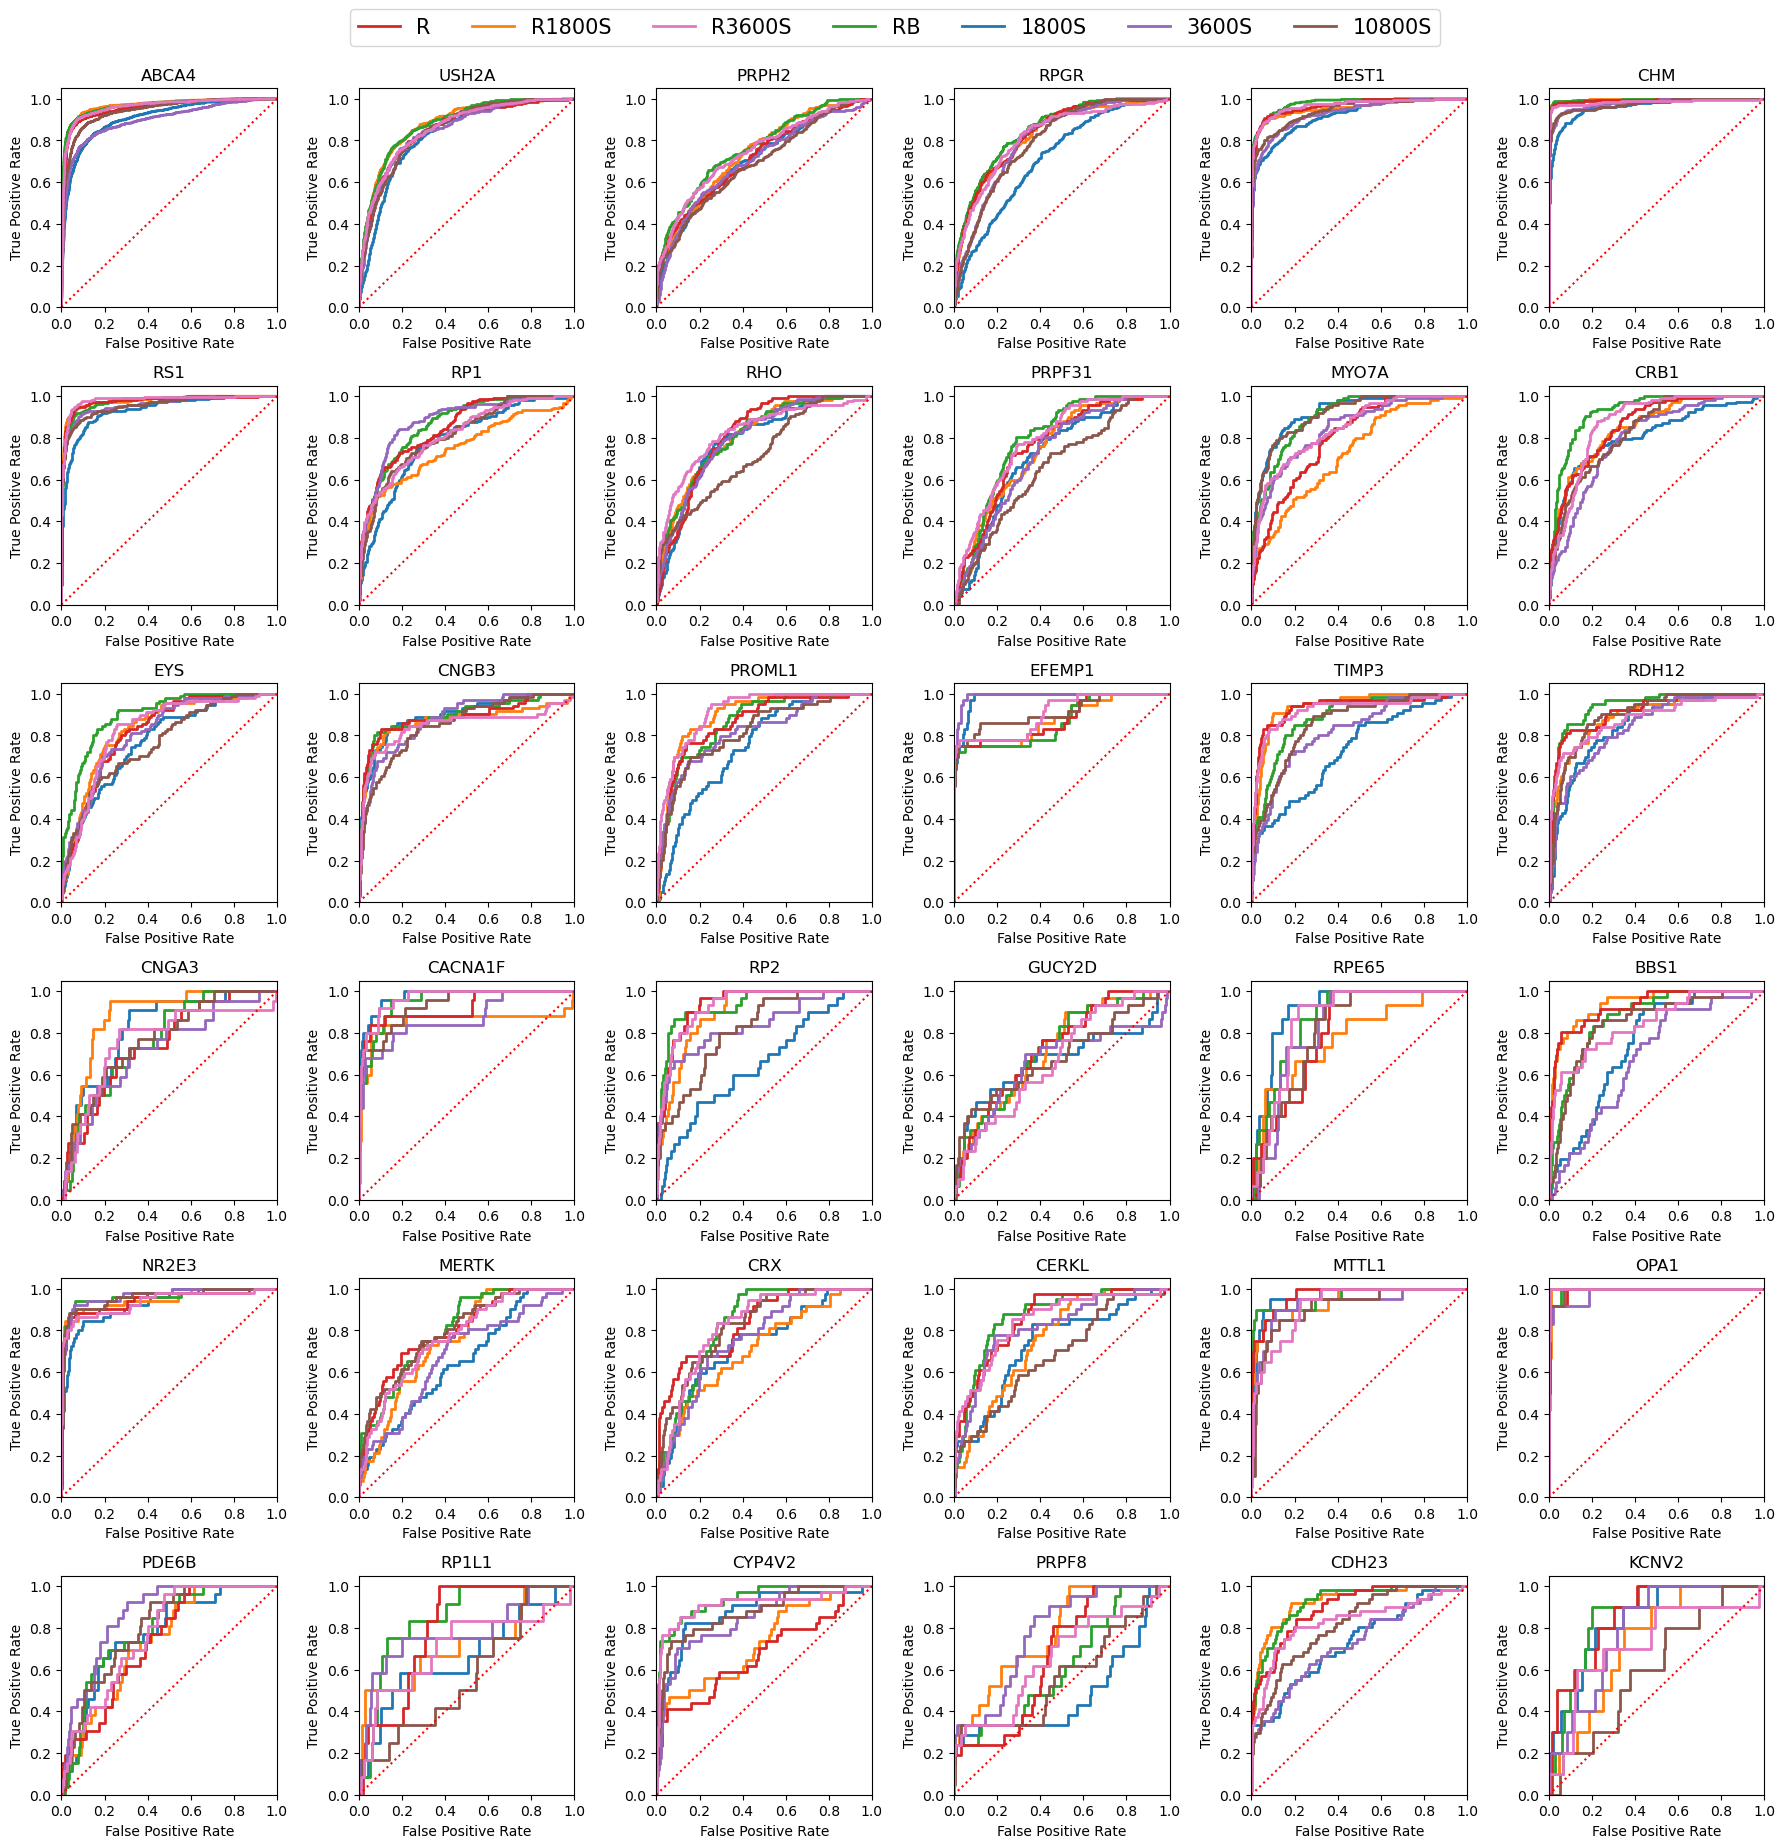

In [63]:
ncols, nrows = 6, 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=(3*ncols, 3*nrows))
aucs = []
    
for i, cls in enumerate(classes):
        
    j = int(np.where(class_ids == i)[0])
    r = j // ncols
    c = j % ncols
    
    # plot model ROC curves
    for k, m in enumerate(models):
        axs[r,c].plot(fpr[m][i],
                      tpr[m][i],
                      alpha=1.,
                      lw=2,
                      label=m)

    # plot low skill classifier
    axs[r,c].title.set_text(classes[i])
    axs[r,c].plot([0, 1], [0, 1],'r:')
    axs[r,c].set_xlim([0, 1])
    axs[r,c].set_ylim([0, 1.05])
    axs[r,c].set_ylabel('True Positive Rate')
    axs[r,c].set_xlabel('False Positive Rate')

h, l = axs[r,c].get_legend_handles_labels()
order = [3, 1, 6, 2, 0, 4 , 5]
h, l = [h[x] for x in order], [l[x] for x in order]
l = ["R", "R1800S", "R3600S", "RB", "1800S", "3600S", "10800S"]
fig.legend(handles=h, labels=l, bbox_to_anchor=(0.5, 1.03), loc="upper center", ncol=7, prop={'size':15})

plt.tight_layout()
plt.show()
plt.close()

In [67]:
roc_auc_results = pd.DataFrame(columns=["gene", *(m for m in models)])

i = 0
for m in classes:
    df2 = {"gene": m}
    for n in roc_auc.keys():
        df2[n] = [roc_auc[n][classes.index(m)]]
    roc_auc_results = pd.concat([roc_auc_results, pd.DataFrame.from_dict(df2, orient='columns')], ignore_index=True)

# rename and reorder columns
old_col_names = [m for m in models]
new_col_names = ["1800S", "R1800S", "RB", "R", "3600S", "10800S", "R3600S"]
mapping = dict(zip(old_col_names, new_col_names))
roc_auc_results = roc_auc_results.rename(columns=mapping)
roc_auc_results = roc_auc_results[["gene", "R", "R1800S", "R3600S", "RB", "1800S", "3600S", "10800S"]]
roc_auc_results

,gene,R,R1800S,R3600S,RB,1800S,3600S,10800S
0,ABCA4,0.951859,0.965396,0.959194,0.964774,0.906748,0.896937,0.941695
1,USH2A,0.853342,0.875736,0.855939,0.881989,0.832879,0.84956,0.853795
2,PRPH2,0.723066,0.744099,0.752709,0.769029,0.712385,0.707039,0.695448
3,RPGR,0.837363,0.826841,0.824582,0.850832,0.716964,0.80883,0.799411
4,BEST1,0.968177,0.957277,0.968609,0.977455,0.919402,0.931845,0.943688
5,CHM,0.993255,0.995904,0.984572,0.996212,0.96093,0.979583,0.974066
6,RS1,0.97674,0.976157,0.983414,0.974503,0.935252,0.960989,0.956591
7,RP1,0.855297,0.75478,0.818916,0.869715,0.788694,0.884003,0.815616
8,RHO,0.819991,0.813821,0.829865,0.815635,0.794221,0.80178,0.725745
9,PRPF31,0.763825,0.747857,0.792902,0.796537,0.722282,0.72713,0.662489


# Visualize Precision-Recall Curves

# Indivitual Plots

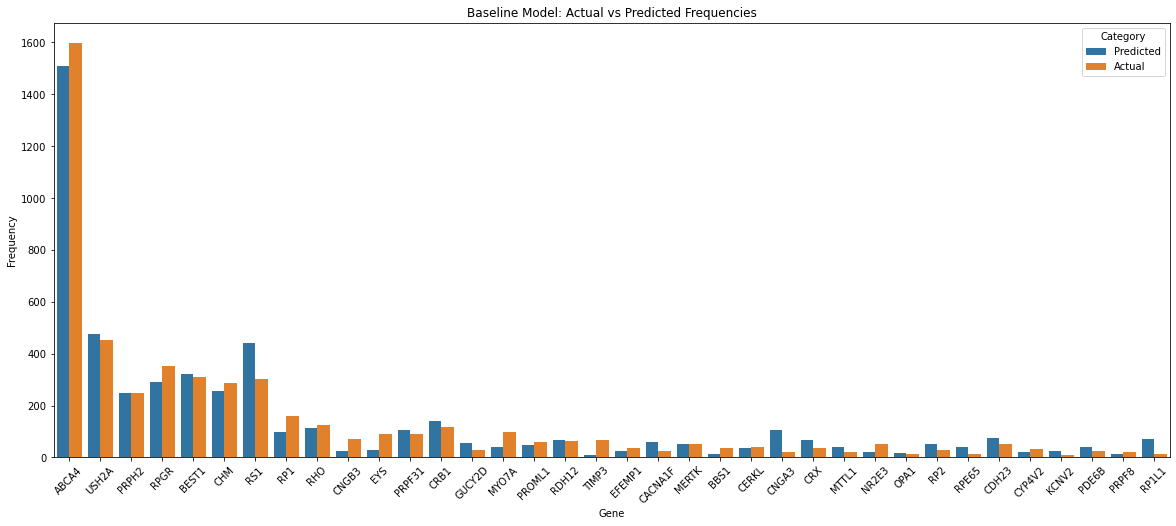

In [54]:
baseline_cm = return_results(baseline_model, classes_rearranged)
plot_frequencies("Baseline Model: Actual vs Predicted Frequencies", baseline_cm, classes_rearranged)